In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
# User Edits
datpath  = "../../CESM_data/Metrics/Detrend_Test/"
outpath = "../../CESM_data/Figures/Detrend_Test/"
leads = np.arange(0,25,3)


In [24]:
def plot_scatter(ypred,yval,ax=None):
    if ax is None:
        ax = plt.gca()
    
    
    # Scatterplot of predictions vs Labels
    ax.scatter(yval,ypred,label="Test",marker='+',zorder=2)
    ax.legend()
    ax.set_ylim([-1.5,1.5])
    ax.set_xlim([-1.5,1.5])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.legend()
    ax.set_xlabel("Actual AMV Index")
    ax.set_ylabel("Predicted AMV Index")
    
    return ax

def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

def calculate_CESM_autocorrelation(detrend,nmembers=40,resolution='2deg'):
    # Calculate AMV Index Autocorrleation
    
    # Load in data [ens x yr x lat x lon]
    sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_Ann.npy' % (resolution)).astype(np.float32)
    lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
    lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
    
    # Detrend if set
    if detrend: # Remove ensemble average
        sst_normed = sst_normed - np.mean(sst_normed,axis=0)[None,:,:,:]
    
    # Calculate Autocorrelation
    tstep = 86
    lags  = 25
    sst_ensemble = calc_AMV_index('NAT',sst_normed[:,:,:,:],lat,lon)
    sst_lagged_corr = np.zeros((nmembers,lags))
    for lead in range(lags):
        sst_lead = sst_ensemble[:,lead:]
        sst_lag = sst_ensemble[:,0:tstep-lead]
        #sss_lag = sss_ensemble[:,0:tstep-lead]

        for ien in range(nmembers):
            sst_lagged_corr[ien,lead] = np.corrcoef( sst_lead[ien,:],sst_lag[ien,:] )[0,1]    
    sst_auto = sst_lagged_corr.copy()
    return sst_auto

In [9]:
# First visualization: Effect of Detrending and dropout

expnames = ["No Detrend, No Droupout","No Detrend, Dropout","Detrend, No Dropout","Detrend, Dropout"]




In [10]:
%%time
# Load data for dropout and detrending experiments, appending into an array
detrend=0
dropout=False

train_loss = []
test_loss  = []
test_corr  = []
yvalpred   = []
yvallabels = []

i = 0
for detrend in [0,1]:
    for dropout in [False,True]:
        fn = "leadtime_testing_ALL_HPT_simplecnn_nepoch20_nens40_maxlead24_detrend%i_noise0_cnndropout%s_ALL.npz" % (detrend,dropout)
        fload = np.load(datpath+fn,allow_pickle=True)
        #print(fload.files)
        train_loss.append(fload['train_loss'])
        test_loss.append(fload['test_loss'])
        test_corr.append(fload['test_corr'])
        yvalpred.append(fload['yvalpred'])
        yvallabels.append(fload['yvallabels'])
        print("Loaded detrend %i, dropout %s into position %i"%(detrend,dropout,i))
        i+=1


Loaded detrend 0, dropout False into position 0
Loaded detrend 0, dropout True into position 1
Loaded detrend 1, dropout False into position 2
Loaded detrend 1, dropout True into position 3
CPU times: user 10.7 ms, sys: 3.37 ms, total: 14 ms
Wall time: 18.8 ms


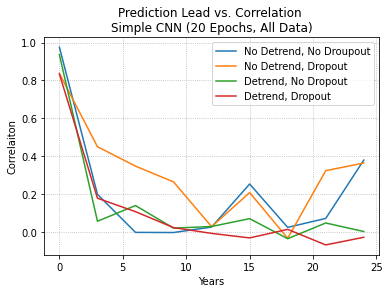

In [50]:
# Plot test correlation
fig,ax = plt.subplots(1,1)
for e,exp in enumerate(expnames):
    ax.plot(leads,test_corr[e],label=exp)

ax.grid("True",linestyle="dotted")
ax.legend()
ax.set_xlabel("Years")
ax.set_ylabel("Correlaiton")
ax.set_title("Prediction Lead vs. Correlation \nSimple CNN (20 Epochs, All Data)")
plt.savefig(outpath+"Detrending_Effects.png",dpi=200)

In [51]:
# Load results of training by noise

expnames2 = ["No Detrend, No Droupout","No Detrend, Dropout","Detrend, No Dropout","Detrend, Dropout"]

train_loss2 = []
test_loss2  = []
test_corr2  = []
yvalpred2   = []
yvallabels2 = []

i = 0
for detrend in [0,1]:
    for dropout in [False,True]:
        fn = "leadtime_testing_ALL_HPT_simplecnn_nepoch20_nens40_maxlead24_detrend%i_noise1_cnndropout%s_ALL.npz" % (detrend,dropout)
        fload = np.load(datpath+fn,allow_pickle=True)
        #print(fload.files)
        train_loss2.append(fload['train_loss'])
        test_loss2.append(fload['test_loss'])
        test_corr2.append(fload['test_corr'])
        yvalpred2.append(fload['yvalpred'])
        yvallabels2.append(fload['yvallabels'])
        print("Loaded dropout %s into position %i"%(dropout,i))
        i+=1

Loaded dropout False into position 0
Loaded dropout True into position 1
Loaded dropout False into position 2
Loaded dropout True into position 3


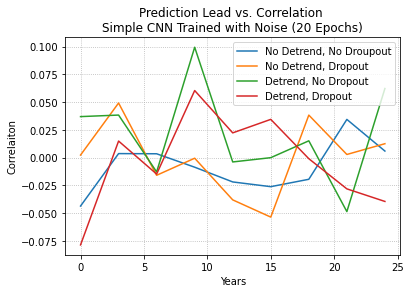

In [54]:
# Plot test correlation
fig,ax = plt.subplots(1,1)
for e,exp in enumerate(expnames2):
    ax.plot(leads,test_corr2[e],label=exp)
ax.grid("True",linestyle="dotted")
ax.legend()
ax.set_xlabel("Years")
ax.set_ylabel("Correlation")
ax.set_title("Prediction Lead vs. Correlation \nSimple CNN Trained with Noise (20 Epochs)")
plt.savefig(outpath+"Noise_Effects.png",dpi=200)

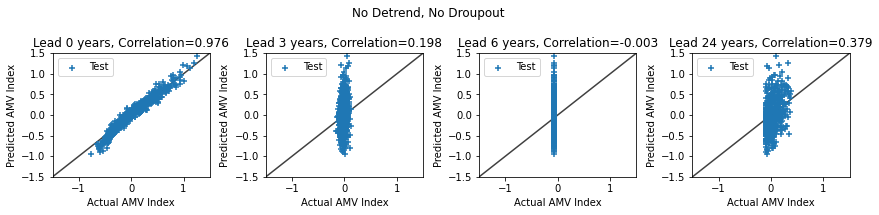

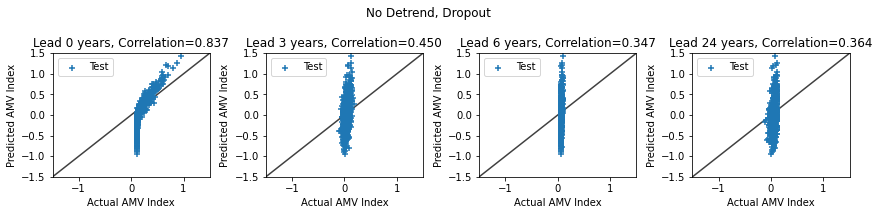

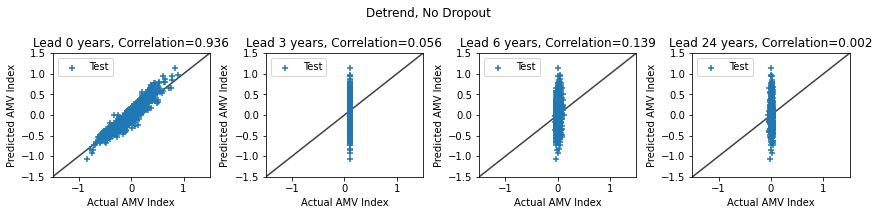

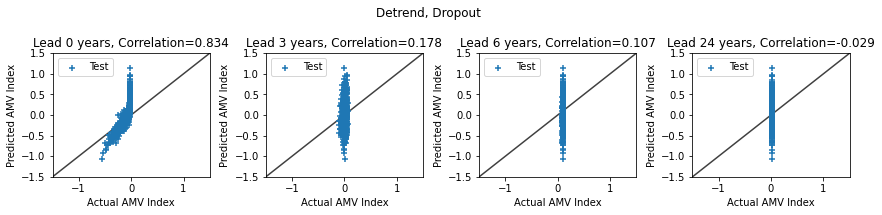

In [44]:
def lead_progression_scatter(leads,plotleads,yvallab,yvalpred,testcorr,figsize=(12,3)):
    """
    plotleads: ARRAY - Indices of the leads to plot
    
    """
    
    nleads = len(plotleads)
    fig,axs = plt.subplots(1,nleads,figsize=figsize)
    
    
    
    # Make Plots
    for i in range(nleads):
        
        klead = np.argwhere(leads==plotleads[i])[0][0]
        
        # Plot for ResNet50
        ax = axs[i]
        ax = plot_scatter(yvallab[klead],yvalpred[klead],ax=ax)
        ax.set_title("Lead %i years, Correlation=%.3f" % (plotleads[i],testcorr[klead]))

    plt.tight_layout()
    return fig,ax
    #plt.savefig(outpath+"ResNet50_Results_scatter.png",dpi=200)
    
for i,exp in enumerate(expnames):
    lead_progression_scatter(leads,[0,3,6,24],yvallabels[i],yvalpred[i],test_corr[i])
    plt.suptitle(exp)
    plt.tight_layout()


# Plots to demonstrate effect of detrending

0
1


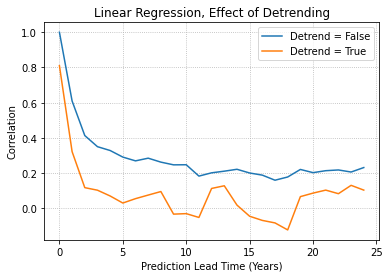

In [34]:
# Load Linear Regression Data
MLR_corr = [] # First is no detrend, second is detrend
for i in [0,1]:
    npzpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Metrics/"
    npzname = "leadtime_testing_ALL_Ann2deg_NAT_MLR_nepoch10_nens40_lead24_detrend%i.npz" % i
    ld = np.load(npzpath+npzname,allow_pickle=True)
    MLR_corr.append(ld['test_corr'])
    print(i)
fig,ax = plt.subplots(1,1)
ax.plot(MLR_corr[0],label="Detrend = False")
ax.plot(MLR_corr[1],label="Detrend = True ")
ax.legend()
ax.grid(True,linestyle="dotted")
ax.set_title("Linear Regression, Effect of Detrending")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
plt.savefig(outpath+"MLR_detrend.png",dpi=200)

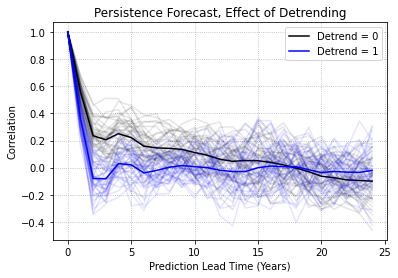

In [35]:
# Calculate CESM Autocorrelation for detrend and no detrending cases
AUTO_corr = []
for i in [0,1]:
    AUTO_corr.append(calculate_CESM_autocorrelation(i))

# Plot Each One
colors = ['k','b']
fig,ax = plt.subplots(1,1)
for i in [0,1]:
    plotvar = AUTO_corr[i]
    for j in range(plotvar.shape[0]):
        ax.plot(plotvar[j],label="",alpha=0.1,color=colors[i])
    ax.plot(plotvar.mean(0),label="Detrend = %i"%i,color=colors[i])
ax.legend()
ax.grid(True,linestyle="dotted")
ax.set_title("Persistence Forecast, Effect of Detrending")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
plt.savefig(outpath+"Persistence_detrend.png",dpi=200)

0
1


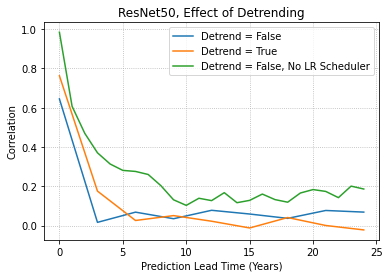

In [120]:
# Load ResNet Data
rn_corr = [] # First is no detrend, second is detrend
for i in [0,1]:
    npzpath = datpath
    npzname = "leadtime_testing_ALL_HPT_resnet50_nepoch20_nens40_maxlead24_detrend%i_noise0_batchsize128_ALL.npz" % i
    ld = np.load(npzpath+npzname,allow_pickle=True)
    rn_corr.append(ld['test_corr'])
    print(i)

ld1 = np.load("/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Metrics/Ablation_Study/leadtime_testing_ALL_Ann244pix_NAT_resnet50_nepoch20_nens40_lead24.npz")
rnold = ld1['test_corr']

fig,ax = plt.subplots(1,1)
ax.plot(leads,rn_corr[0],label="Detrend = False")
ax.plot(leads,rn_corr[1],label="Detrend = True ")
ax.plot(rnold,label="Detrend = False, No LR Scheduler")
ax.legend()
ax.grid(True,linestyle="dotted")
ax.set_title("ResNet50, Effect of Detrending")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
plt.savefig(outpath+"RNN_detrend.png",dpi=200)

0
1


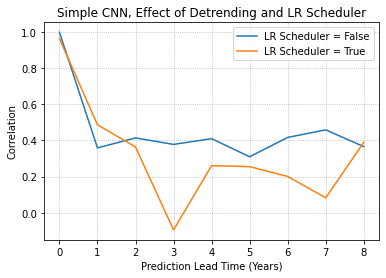

In [75]:
#load Simplecnn Data (TESTING LR SCHEDULER)
cnn_corr_LR = [] # First is no detrend, second is detrend
for i in [0,1]:
    npzpath = datpath
    if i == 1:
        npzname = "leadtime_testing_ALL_HPT_simplecnn_nepoch20_nens40_maxlead24_detrend0_noise0_cnndropoutFalse_ALL_scheduler%i.npz" % i
    else:
        npzname = "leadtime_testing_ALL_HPT_simplecnn_nepoch20_nens40_maxlead24_detrend0_noise0_cnndropoutFalse_ALL_scheduler%i_02.npz" % i
    ld = np.load(npzpath+npzname,allow_pickle=True)
    cnn_corr_LR.append(ld['test_corr'])
    print(i)

fig,ax = plt.subplots(1,1)
ax.plot(cnn_corr_LR[0],label="LR Scheduler = False")
ax.plot(cnn_corr_LR[1],label="LR Scheduler = True ")
ax.legend()
ax.grid(True,linestyle="dotted")
ax.set_title("Simple CNN, Effect of Detrending and LR Scheduler")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
plt.savefig(outpath+"simplecnn_detrend_LRScheduler.png",dpi=200)

0
1


Text(0.5, 0, 'Prediction Lead Time (Years)')

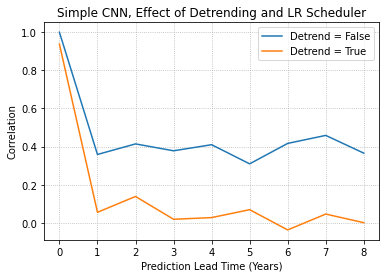

In [80]:
#load Simplecnn Data
cnn_corr = [] # First is no detrend, second is detrend
for i in [0,1]:
    npzpath = datpath
    if i == 1:
        npzname = "leadtime_testing_ALL_HPT_simplecnn_nepoch20_nens40_maxlead24_detrend1_noise0_cnndropoutFalse_ALL.npz"
    else:
        npzname = "leadtime_testing_ALL_HPT_simplecnn_nepoch20_nens40_maxlead24_detrend0_noise0_cnndropoutFalse_ALL_scheduler%i_02.npz" % i
    ld = np.load(npzpath+npzname,allow_pickle=True)
    cnn_corr.append(ld['test_corr'])
    print(i)

fig,ax = plt.subplots(1,1)
ax.plot(cnn_corr[0],label="Detrend = False")
ax.plot(cnn_corr[1],label="Detrend = True ")
ax.legend()
ax.grid(True,linestyle="dotted")
ax.set_title("Simple CNN, Effect of Detrending and LR Scheduler")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (Years)")
#plt.savefig(outpath+"simplecnn_detrend_LRScheduler.png",dpi=200)

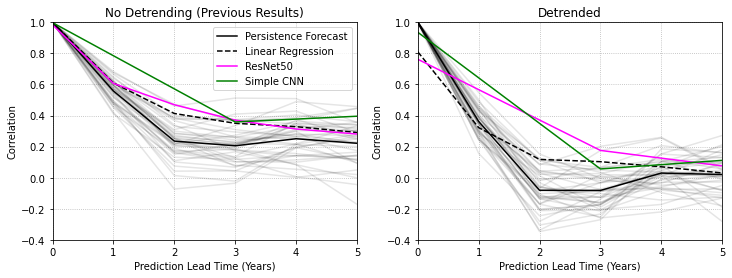

In [121]:
# Overall plot, showcasing the effect of detrending
ylm = [-.4,1]
xlm = [0,5]

fig,axs = plt.subplots(1,2,figsize=(12,4))

d = 0
ax = axs[0]
ax.set_title("No Detrending (Previous Results)")
ax.set_ylabel("Correlation")
ax.grid(True,ls='dotted')
for i in range(40):
    ax.plot(AUTO_corr[d][i,:],label="",alpha=0.1,color='k')
ax.plot(AUTO_corr[d].mean(0),label="Persistence Forecast",color='k')
ax.plot(MLR_corr[d],label="Linear Regression",ls='dashed',color='k')
#ax.plot(leads,rn_corr[d],label="ResNet50",color='magenta') 
ax.plot(rnold,label="ResNet50",color='magenta') 
ax.plot(leads,cnn_corr[d],label="Simple CNN",color="green")
ax.legend()
ax.set_ylim(ylm)
ax.set_xlim(xlm)
ax.set_xlabel("Prediction Lead Time (Years)")


d = 1
ax = axs[1]
ax.set_title("Detrended")
ax.set_ylabel("Correlation")
ax.grid(True,ls='dotted')
for i in range(40):
    ax.plot(AUTO_corr[d][i,:],label="",alpha=0.1,color='k')
ax.plot(AUTO_corr[d].mean(0),label="Persistence Forecast",color='k')
ax.plot(MLR_corr[d],label="Linear Regression",ls='dashed',color='k')
ax.plot(leads,rn_corr[d],label="ResNet50",color='magenta') 
ax.plot(leads,cnn_corr[d],label="Simple CNN",color="green")
ax.set_ylim(ylm)
ax.set_xlim(xlm)
ax.set_xlabel("Prediction Lead Time (Years)")

plt.savefig(outpath+"Detrending_All_Comparison_5yr.png",dpi=200)

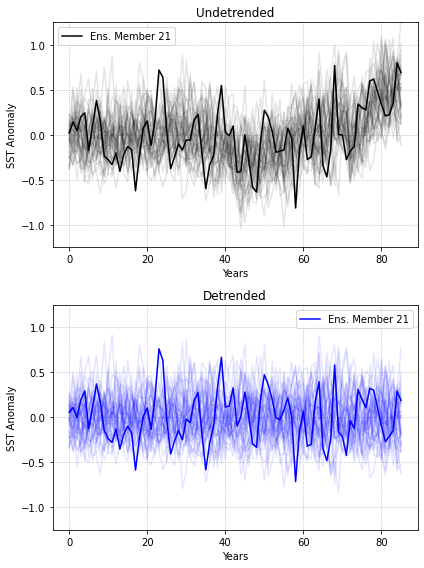

In [119]:
# Sample plot of how detrending looks like
ylm = [-1.25,1.25]
resolution='2deg'
sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_Ann.npy' % (resolution)).astype(np.float32)
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))

if detrend: # Remove ensemble average
    sst_normed_dt = sst_normed - np.mean(sst_normed,axis=0)[None,:,:,:]

# Calculate Autocorrelation
tstep = 86
lags  = 25
sst_ensemble = calc_AMV_index('NAT',sst_normed[:,:,:,:],lat,lon)
sst_ensemble_dt = calc_AMV_index('NAT',sst_normed_dt[:,:,:,:],lat,lon)


fig,axs = plt.subplots(2,1,figsize=(6,8))


e = 20
ax=axs[0]
for i in range(40):
    ax.plot(sst_ensemble[i,:],label="",color="k",alpha=0.1)
ax.plot(sst_ensemble[e,:],color="k",label="Ens. Member %i"% (e+1))
ax.set_title("Undetrended")
ax.legend()
ax.set_xlabel("Years")
ax.set_ylabel("SST Anomaly")
ax.set_ylim(ylm)
ax.grid(True,ls='dotted')

ax=axs[1]
for i in range(40):
    ax.plot(sst_ensemble_dt[i,:],label="",color="b",alpha=0.1)
ax.plot(sst_ensemble_dt[e,:],color="b",label="Ens. Member %i"% (e+1))  
ax.set_title("Detrended")
ax.legend()
ax.set_xlabel("Years")
ax.set_ylabel("SST Anomaly")
ax.set_ylim(ylm)
ax.grid(True,ls='dotted')

plt.tight_layout()
plt.savefig(outpath+"Detrending Example.png",dpi=200)